In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import utils
#import paint_auth as pa
from lxml import etree as ET
from collections import Counter

In [4]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#import all xml and convert to pd dataframe
#only extract painters
path = './data/sub_xml2'
file_names = glob.glob(path+'/**')

#initialize dict and parser
info = {}
parser = ET.XMLParser(recover=True)
for i in range(len(file_names)):
    im_name = file_names[i].split('/')[-1]
    tree = ET.parse(file_names[i], parser)
    title, artist, medium, period = utils.extract_xml_info(tree.getroot())
    #medium == 'schilderij'
    if medium == 'tekening': #painting or drawing in Dutch...  or medium == 'tekening' 
        if artist is not None:
            artist = artist.split(': ')[-1]
        im_name = im_name.split('.xml')[0]
        info[i] = (im_name, title, artist, medium, period)

info = pd.DataFrame.from_dict(info, 'index').rename(index=str, columns={0:'file_name', 1:'title', 2:'artist', 3:'medium', 4:'period'})

In [6]:
# #getting labels
# labels, label_map = utils.get_labels(info)
# num_classes=max(labels)
# #editing .jpg paths
# path = './data/sub_jpg2'
# file_names = [n.split('/sub_xml2/')[-1] for n in file_names]
# file_names = [n.split('.xml')[0] for n in file_names]
# file_names = [path + '/' + n + '.jpg' for n in file_names]

In [7]:
#if only drawings...
labels, label_map = utils.get_labels(info)
num_classes = len(pd.unique(labels))
path = './data/sub_jpg2/'
file_names = info['file_name']
file_names = [path + n + '.jpg' for n in file_names]

In [8]:
#processing training and val dataset
val_size = 0.2
val_i = int(len(file_names) * (1 - val_size))

train_file_names = file_names[:val_i]
train_labels = labels[:val_i]
val_file_names = file_names[val_i:]
val_labels = labels[val_i:]

In [9]:
print 'training size: %d' % len(train_labels)
print 'val size: %d' % len(val_labels)

training size: 1948
val size: 488


In [10]:
reload(utils)

<module 'utils' from 'utils.pyc'>

In [11]:
BATCH_SIZE=64

#train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_names, train_labels))
# train_dataset = train_dataset.map(utils.preprocess_image)

#applyflip in train
train_dataset = train_dataset.map(utils.preprocess_image_flip)
train_dataset = train_dataset.shuffle(10000)
batch_train_dataset = train_dataset.batch(BATCH_SIZE)

#val dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_names, val_labels))
val_dataset = val_dataset.map(utils.val_preprocess_image)
batch_val_dataset = val_dataset.batch(BATCH_SIZE)


In [12]:
#setting up iterator for dataset
iterator = tf.data.Iterator.from_structure(batch_train_dataset.output_types,
                                                   batch_train_dataset.output_shapes)
images, labels = iterator.get_next()


train_init_op = iterator.make_initializer(batch_train_dataset)
val_init_op = iterator.make_initializer(batch_val_dataset)

# Indicates whether we are in training or in test mode
is_training = tf.placeholder(tf.bool)

In [13]:
#setting up pretrained resnet trained on Imagenet
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope

In [14]:
#tf.reset_default_graph()

In [15]:
#note graph init. should only be ran once, use above cell to reset graph to run more than once
with slim.arg_scope(inception_resnet_v2_arg_scope()): #default parameter
    output, _ = inception_resnet_v2(images, num_classes=num_classes, is_training=is_training) #initialize model

In [16]:
output

<tf.Tensor 'InceptionResnetV2/Logits/Logits/BiasAdd:0' shape=(?, 13) dtype=float32>

In [17]:
tf.contrib.framework.get_variables('InceptionResnetV2/Logits')

[<tf.Variable 'InceptionResnetV2/Logits/Logits/weights:0' shape=(1536, 13) dtype=float32_ref>,
 <tf.Variable 'InceptionResnetV2/Logits/Logits/biases:0' shape=(13,) dtype=float32_ref>]

In [18]:
#loading from checkpoint
ckpt_path = './checkpoint/inception_resnet_v2_2016_08_30.ckpt'

#exclude output layer as it has different class size
variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits'])
init_fn = tf.contrib.framework.assign_from_checkpoint_fn(ckpt_path, variables_to_restore) #call to load weights

In [19]:
#define new logits variables
logits_variables = tf.contrib.framework.get_variables('InceptionResnetV2/Logits')
logits_init = tf.variables_initializer(logits_variables)
auxlogits_variables = tf.contrib.framework.get_variables('InceptionResnetV2/AuxLogits')
auxlogits_init = tf.variables_initializer(auxlogits_variables)

In [20]:
logits_variables

[<tf.Variable 'InceptionResnetV2/Logits/Logits/weights:0' shape=(1536, 13) dtype=float32_ref>,
 <tf.Variable 'InceptionResnetV2/Logits/Logits/biases:0' shape=(13,) dtype=float32_ref>]

In [17]:
#define optimizers and loss
#optimizers initialized multiple times for each specific set of weights
alpha = 5e-4
one_hot_labels = tf.one_hot(labels, num_classes)
tf.losses.softmax_cross_entropy(one_hot_labels, output) #allows easy access for loss from tf.GraphKeys.losses
loss = tf.losses.get_total_loss()

logit_optimizer = tf.train.GradientDescentOptimizer(alpha)
auxlogit_optimizer = tf.train.GradientDescentOptimizer(alpha)

#train only logis/auxlogis variables
logit_train_op = logit_optimizer.minimize(loss, var_list=logits_variables)
auxlogit_train_op = auxlogit_optimizer.minimize(loss, var_list=auxlogits_variables)

#train all weights using same optimizer
alpha2 = 5e-5
full_optimizer = tf.train.GradientDescentOptimizer(alpha2)
full_train_op = full_optimizer.minimize(loss)

In [18]:
# #evals
predictions = tf.to_int32(tf.argmax(output, 1))
correct_predictions = tf.equal(predictions, labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [19]:
# #evals
# predictions = tf.to_int32(tf.argmax(output, 1))
# accuracy = tf.reduce_mean(tf.cast((predictions - labels) == 0,tf.int32))

In [20]:
#graph read only
# tf.get_default_graph().finalize()

In [21]:
# def check_accuracy(sess, accuracy, is_training, dataset_train_op):
#     sess.run(dataset_train_op)
#     total_acc = 0
#     while True: #run while non-empty iterator
#         try:
#             acc = sess.run(accuracy, {is_training:False})
#             print acc
#             total_acc += acc
#         except tf.errors.OutOfRangeError:
#             break
        
#     return np.mean(total_acc)

In [22]:
def get_predictions(sess, predictions, labels, is_training, dataset_train_op):
    sess.run(dataset_train_op)
    my_predictions = []
    my_labels = []
    while True:
        try:
            my_predictions.append(sess.run(predictions, {is_training:False}))
            my_labels.append(sess.run(labels))
        except tf.errors.OutOfRangeError:
            break
    
    return my_predictions, my_labels
        
            

In [23]:
def check_accuracy(sess, correct_prediction, is_training, dataset_init_op):
    """
    Check the accuracy of the model on either train or val (depending on dataset_init_op).
    """
    # Initialize the correct dataset
    sess.run(dataset_init_op)
    num_correct, num_samples = 0, 0
    while True:
        try:
            correct_pred = sess.run(correct_prediction, {is_training: False})
            num_correct += correct_pred.sum()
            num_samples += correct_pred.shape[0]
        except tf.errors.OutOfRangeError:
            break

    # Return the fraction of datapoints that were correctly classified
    acc = float(num_correct) / num_samples
    return acc

In [24]:
sess = tf.Session()

# init. from scratch
# init_fn(sess)
# sess.run(logits_init)
# sess.run(auxlogits_init)

# init. from mid-train
chkpt_dir = './checkpoint/rijks_inception_resnet_v2/'
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(chkpt_dir))

INFO:tensorflow:Restoring parameters from ./checkpoint/rijks_inception_resnet_v2/rijks_inception_resnet_v2.ckpt


In [25]:
#bookeeping
epochs = 20000
train_acc_all = []
val_acc_all = []

Starting epoch: 1 / 20000
training... done
Train Acc.: 0.200205
Val. Acc.: 0.178279


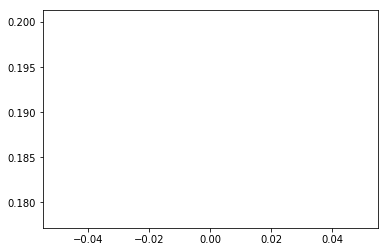

Starting epoch: 2 / 20000
training... done
Train Acc.: 0.185832
Val. Acc.: 0.176230


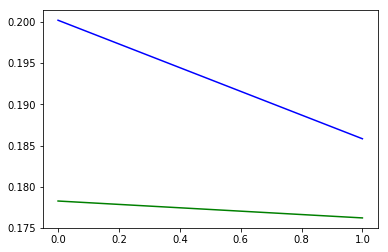

Starting epoch: 3 / 20000
training... done
Train Acc.: 0.191478
Val. Acc.: 0.176230


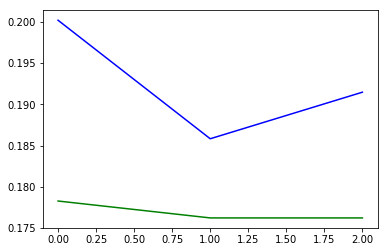

Starting epoch: 4 / 20000
training... done
Train Acc.: 0.193532
Val. Acc.: 0.176230


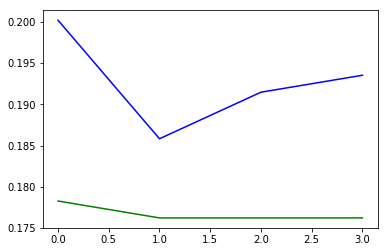

Starting epoch: 5 / 20000
training... done
Train Acc.: 0.190965
Val. Acc.: 0.180328


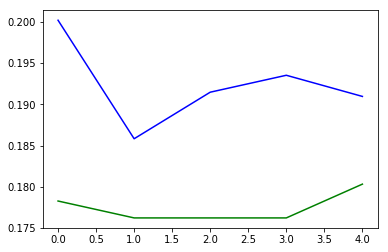

Starting epoch: 6 / 20000
training... done
Train Acc.: 0.191992
Val. Acc.: 0.178279


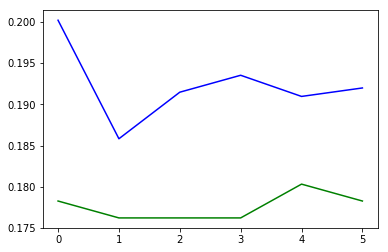

Starting epoch: 7 / 20000
training... done
Train Acc.: 0.193018
Val. Acc.: 0.176230


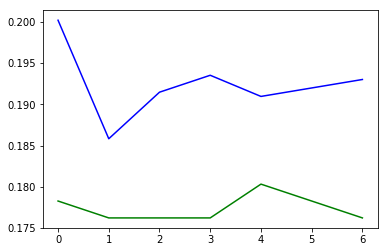

Starting epoch: 8 / 20000
training... done
Train Acc.: 0.188398
Val. Acc.: 0.176230


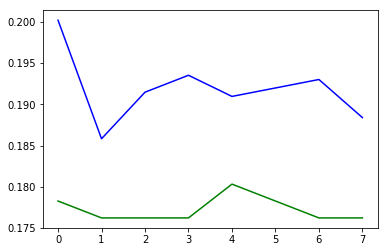

Starting epoch: 9 / 20000
training... done
Train Acc.: 0.187885
Val. Acc.: 0.176230


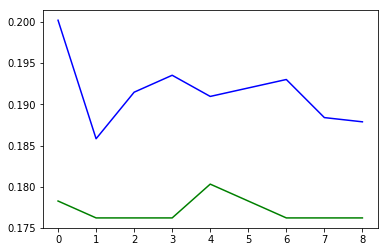

Starting epoch: 10 / 20000
training... done
Train Acc.: 0.190965
Val. Acc.: 0.176230


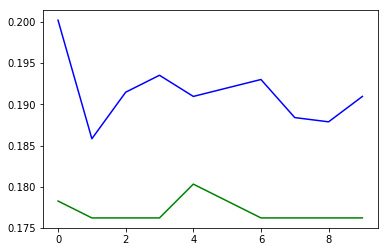

Starting epoch: 11 / 20000
training... done
Train Acc.: 0.194559
Val. Acc.: 0.178279


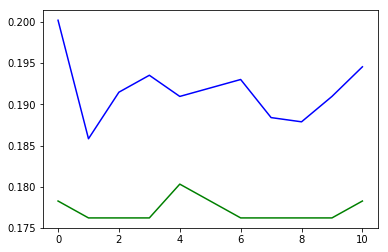

Starting epoch: 12 / 20000
training... done
Train Acc.: 0.193018
Val. Acc.: 0.178279


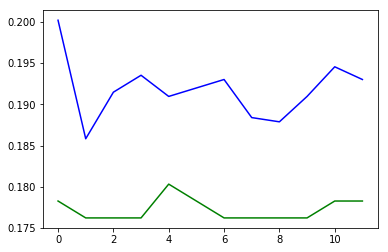

Starting epoch: 13 / 20000
training... done
Train Acc.: 0.194559
Val. Acc.: 0.178279


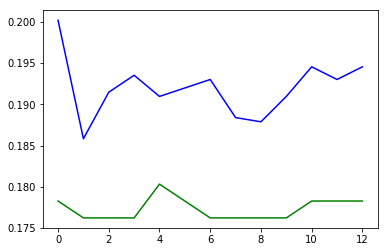

Starting epoch: 14 / 20000
training... done
Train Acc.: 0.189938
Val. Acc.: 0.178279


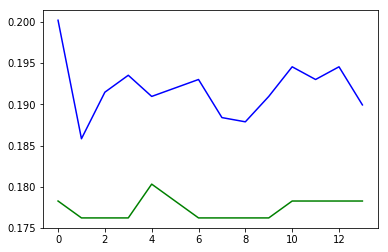

Starting epoch: 15 / 20000
training... done
Train Acc.: 0.197639
Val. Acc.: 0.178279


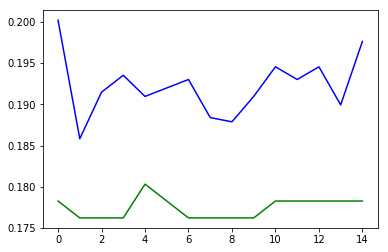

Starting epoch: 16 / 20000
training... done
Train Acc.: 0.191992
Val. Acc.: 0.178279


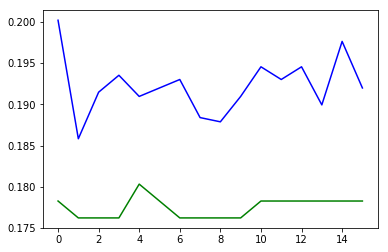

Starting epoch: 17 / 20000
training... done
Train Acc.: 0.191992
Val. Acc.: 0.178279


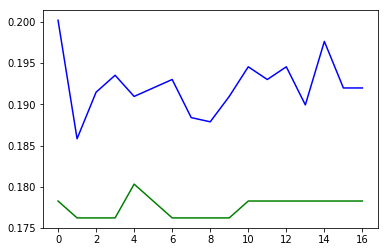

Starting epoch: 18 / 20000
training... done
Train Acc.: 0.193018
Val. Acc.: 0.178279


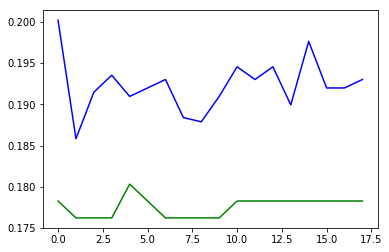

Starting epoch: 19 / 20000
training... done
Train Acc.: 0.193532
Val. Acc.: 0.180328


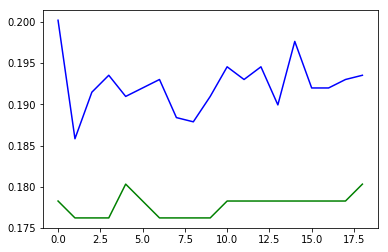

Starting epoch: 20 / 20000
training... done
Train Acc.: 0.187372
Val. Acc.: 0.180328


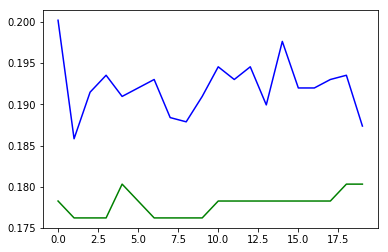

Starting epoch: 21 / 20000
training... done
Train Acc.: 0.189938
Val. Acc.: 0.182377


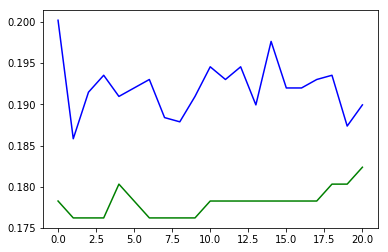

Starting epoch: 22 / 20000
training... done
Train Acc.: 0.194045
Val. Acc.: 0.182377


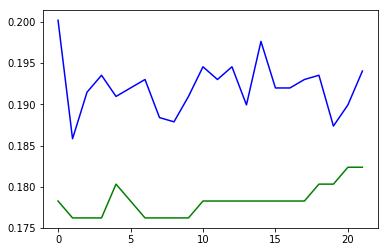

Starting epoch: 23 / 20000
training... done
Train Acc.: 0.193532
Val. Acc.: 0.180328


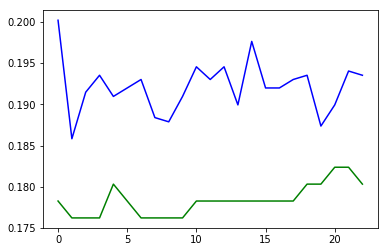

Starting epoch: 24 / 20000
training... done
Train Acc.: 0.193532
Val. Acc.: 0.180328


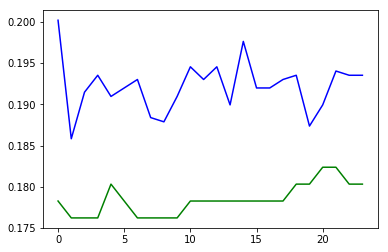

Starting epoch: 25 / 20000
training... done
Train Acc.: 0.190452
Val. Acc.: 0.180328


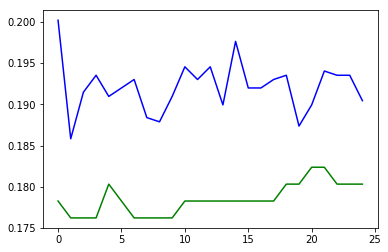

Starting epoch: 26 / 20000
training... done
Train Acc.: 0.192505
Val. Acc.: 0.180328


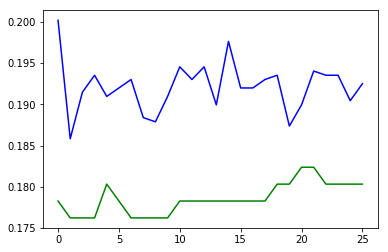

Starting epoch: 27 / 20000
training... done
Train Acc.: 0.195585
Val. Acc.: 0.180328


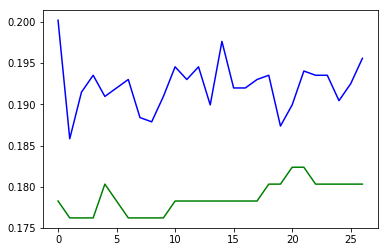

Starting epoch: 28 / 20000
training... done
Train Acc.: 0.187372
Val. Acc.: 0.182377


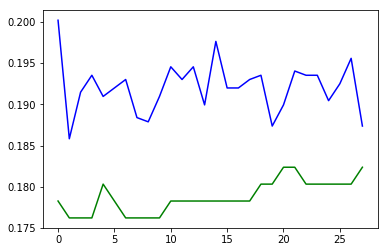

Starting epoch: 29 / 20000
training... done
Train Acc.: 0.188398
Val. Acc.: 0.182377


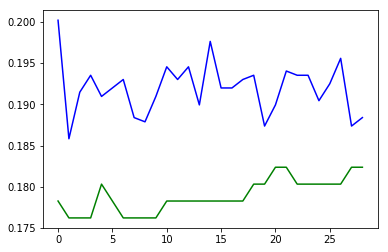

Starting epoch: 30 / 20000
training... done
Train Acc.: 0.191992
Val. Acc.: 0.182377


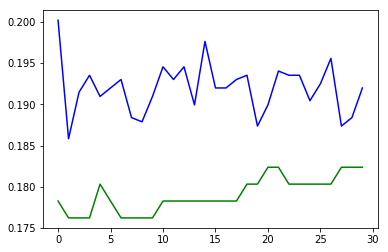

Starting epoch: 31 / 20000
training... done
Train Acc.: 0.196099
Val. Acc.: 0.182377


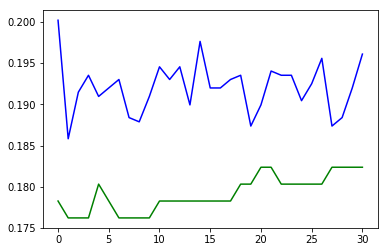

Starting epoch: 32 / 20000
training... done
Train Acc.: 0.201232
Val. Acc.: 0.182377


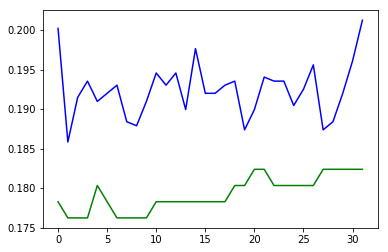

Starting epoch: 33 / 20000
training... done
Train Acc.: 0.195585
Val. Acc.: 0.182377


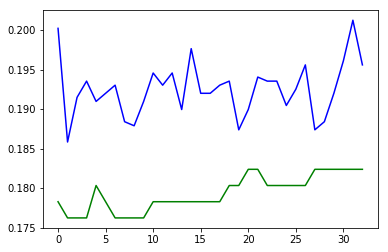

Starting epoch: 34 / 20000
training... done
Train Acc.: 0.194559
Val. Acc.: 0.182377


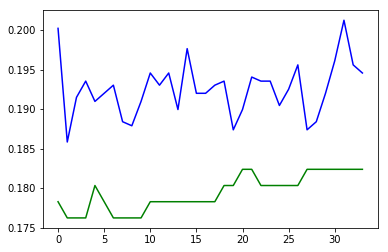

Starting epoch: 35 / 20000
training... done
Train Acc.: 0.196612
Val. Acc.: 0.182377


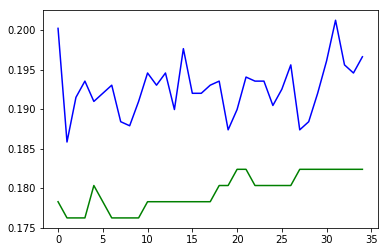

Starting epoch: 36 / 20000
training... done
Train Acc.: 0.194045
Val. Acc.: 0.182377


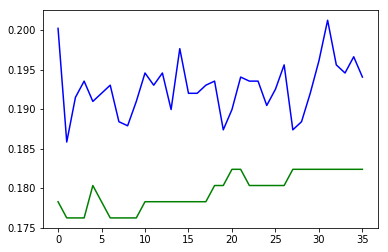

Starting epoch: 37 / 20000
training... done
Train Acc.: 0.192505
Val. Acc.: 0.182377


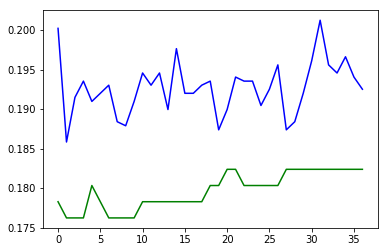

Starting epoch: 38 / 20000
training... done
Train Acc.: 0.186858
Val. Acc.: 0.182377


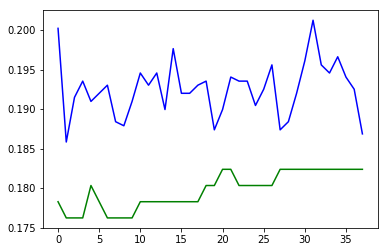

Starting epoch: 39 / 20000
training... done
Train Acc.: 0.192505
Val. Acc.: 0.184426


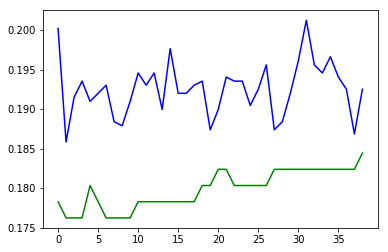

Starting epoch: 40 / 20000
training... done
Train Acc.: 0.195585
Val. Acc.: 0.186475


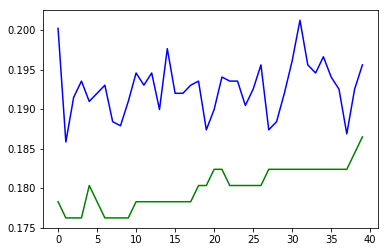

Starting epoch: 41 / 20000
training... done
Train Acc.: 0.197125
Val. Acc.: 0.186475


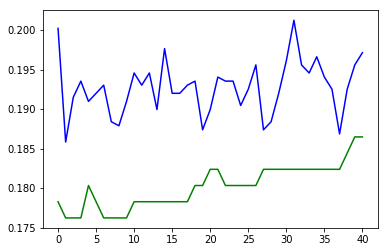

Starting epoch: 42 / 20000
training... done
Train Acc.: 0.200205
Val. Acc.: 0.188525


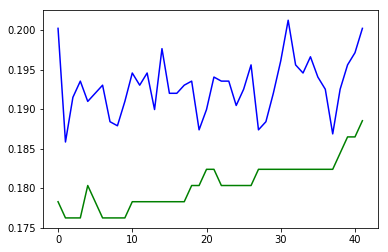

Starting epoch: 43 / 20000
training... done
Train Acc.: 0.197639
Val. Acc.: 0.188525


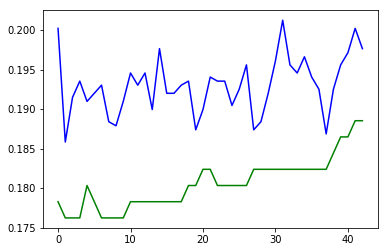

Starting epoch: 44 / 20000
training... done
Train Acc.: 0.191478
Val. Acc.: 0.186475


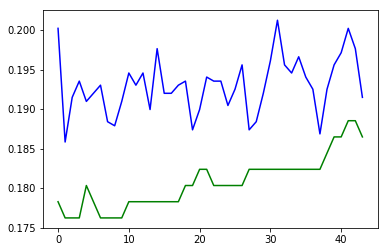

Starting epoch: 45 / 20000
training... done
Train Acc.: 0.198665
Val. Acc.: 0.188525


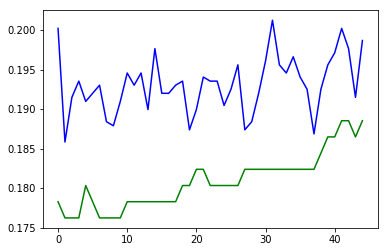

Starting epoch: 46 / 20000
training... done
Train Acc.: 0.196099
Val. Acc.: 0.188525


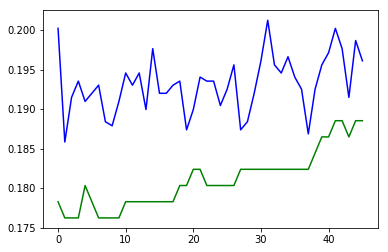

Starting epoch: 47 / 20000
training... done
Train Acc.: 0.196612
Val. Acc.: 0.192623


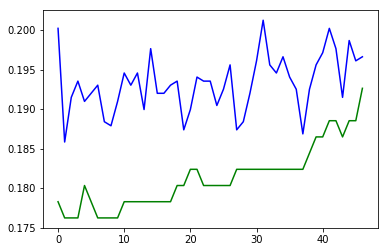

Starting epoch: 48 / 20000
training... done
Train Acc.: 0.196099
Val. Acc.: 0.194672


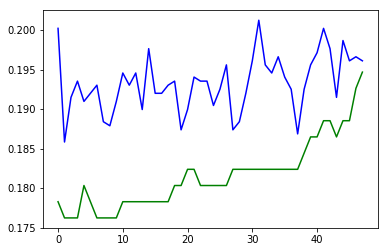

Starting epoch: 49 / 20000
training... done
Train Acc.: 0.199179
Val. Acc.: 0.194672


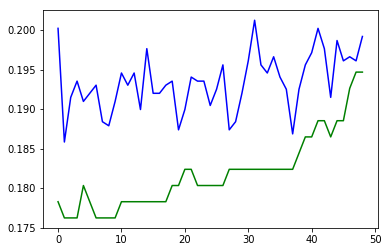

Starting epoch: 50 / 20000
training... done
Train Acc.: 0.203799
Val. Acc.: 0.194672


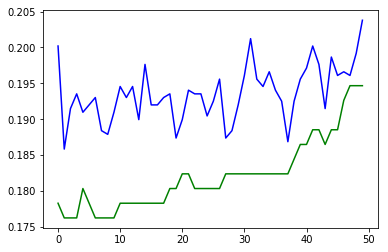

Starting epoch: 51 / 20000
training... done
Train Acc.: 0.196099
Val. Acc.: 0.194672


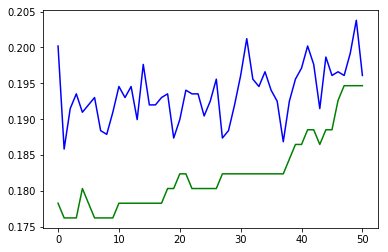

Starting epoch: 52 / 20000
training... done
Train Acc.: 0.200719
Val. Acc.: 0.194672


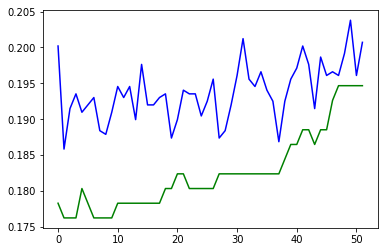

Starting epoch: 53 / 20000
training... done
Train Acc.: 0.199179
Val. Acc.: 0.196721


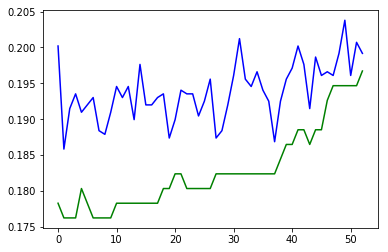

Starting epoch: 54 / 20000
training... done
Train Acc.: 0.199179
Val. Acc.: 0.196721


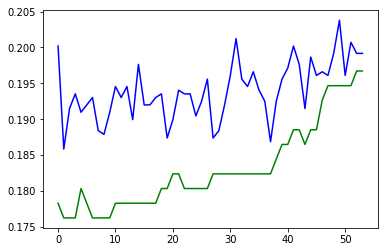

Starting epoch: 55 / 20000
training... done
Train Acc.: 0.200205
Val. Acc.: 0.194672


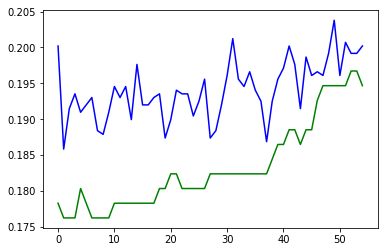

Starting epoch: 56 / 20000
training... done
Train Acc.: 0.198665
Val. Acc.: 0.196721


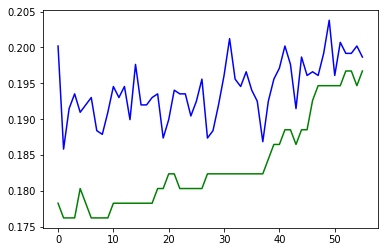

Starting epoch: 57 / 20000
training... done
Train Acc.: 0.201232
Val. Acc.: 0.196721


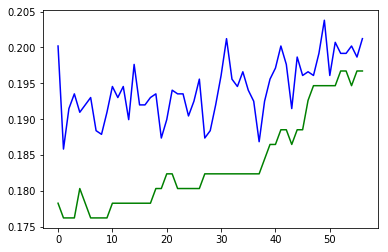

Starting epoch: 58 / 20000
training... done
Train Acc.: 0.205339
Val. Acc.: 0.196721


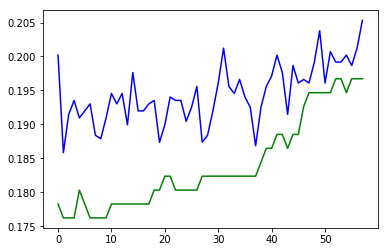

Starting epoch: 59 / 20000
training... done
Train Acc.: 0.198665
Val. Acc.: 0.198770


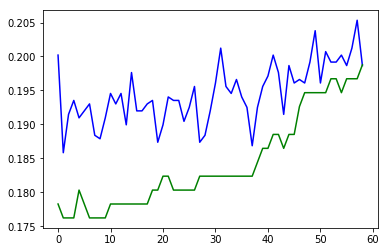

Starting epoch: 60 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.198770


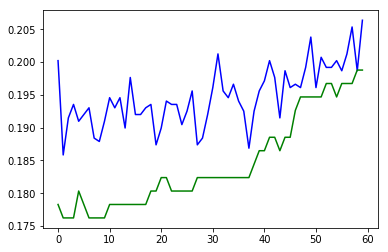

Starting epoch: 61 / 20000
training... done
Train Acc.: 0.200719
Val. Acc.: 0.198770


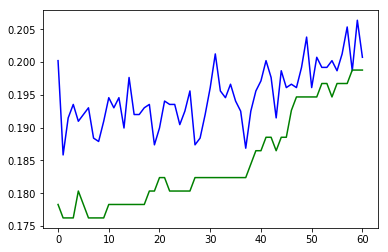

Starting epoch: 62 / 20000
training... done
Train Acc.: 0.205339
Val. Acc.: 0.198770


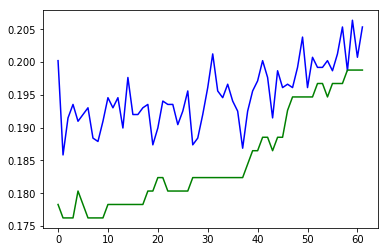

Starting epoch: 63 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.198770


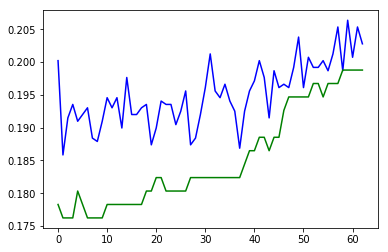

Starting epoch: 64 / 20000
training... done
Train Acc.: 0.201745
Val. Acc.: 0.198770


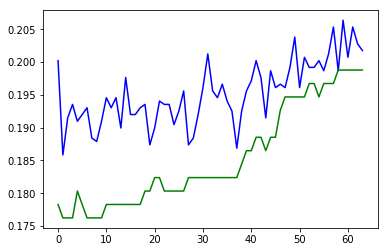

Starting epoch: 65 / 20000
training... done
Train Acc.: 0.198152
Val. Acc.: 0.198770


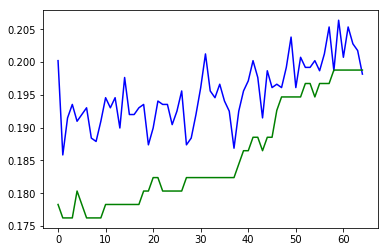

Starting epoch: 66 / 20000
training... done
Train Acc.: 0.198152
Val. Acc.: 0.200820


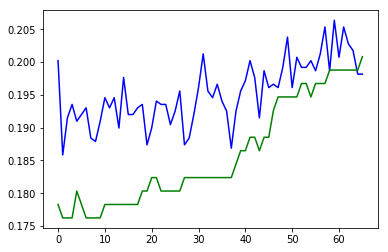

Starting epoch: 67 / 20000
training... done
Train Acc.: 0.198152
Val. Acc.: 0.200820


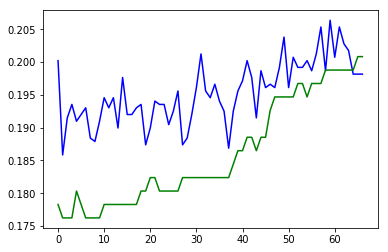

Starting epoch: 68 / 20000
training... done
Train Acc.: 0.206879
Val. Acc.: 0.200820


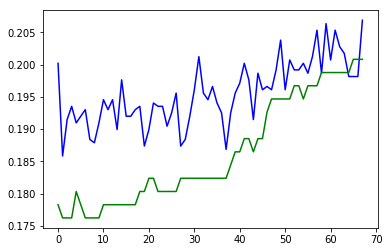

Starting epoch: 69 / 20000
training... done
Train Acc.: 0.199179
Val. Acc.: 0.200820


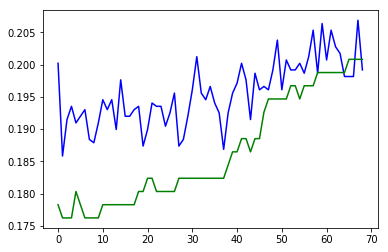

Starting epoch: 70 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.198770


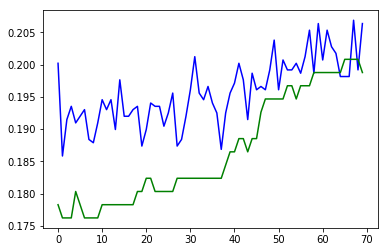

Starting epoch: 71 / 20000
training... done
Train Acc.: 0.206879
Val. Acc.: 0.198770


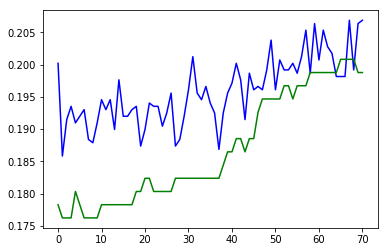

Starting epoch: 72 / 20000
training... done
Train Acc.: 0.201232
Val. Acc.: 0.198770


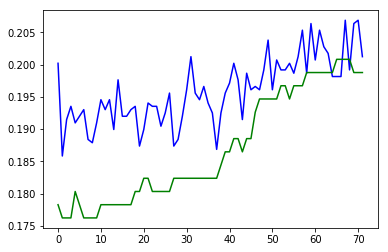

Starting epoch: 73 / 20000
training... done
Train Acc.: 0.201232
Val. Acc.: 0.198770


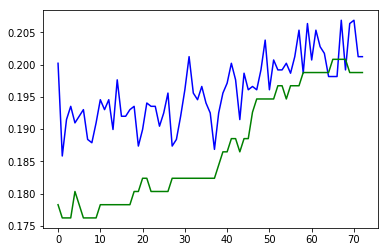

Starting epoch: 74 / 20000
training... done
Train Acc.: 0.207392
Val. Acc.: 0.200820


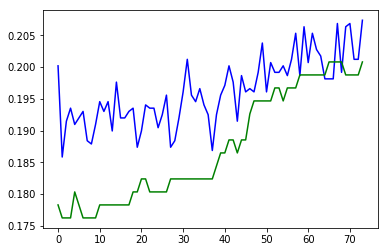

Starting epoch: 75 / 20000
training... done
Train Acc.: 0.203285
Val. Acc.: 0.200820


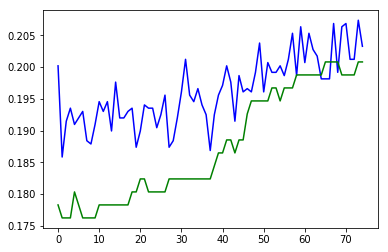

Starting epoch: 76 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.198770


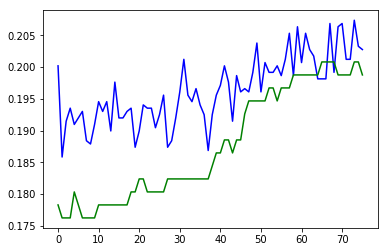

Starting epoch: 77 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.200820


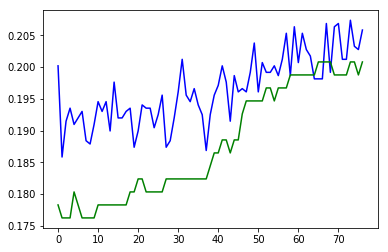

Starting epoch: 78 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.200820


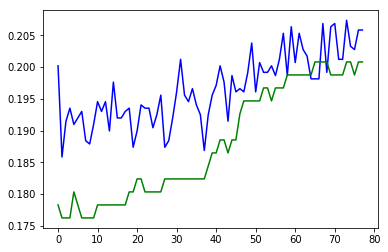

Starting epoch: 79 / 20000
training... done
Train Acc.: 0.202259
Val. Acc.: 0.200820


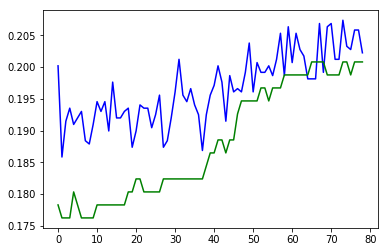

Starting epoch: 80 / 20000
training... done
Train Acc.: 0.203285
Val. Acc.: 0.198770


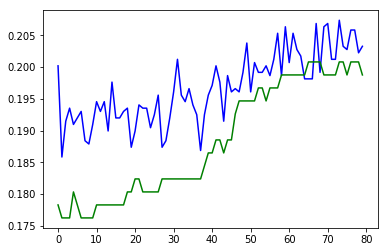

Starting epoch: 81 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.198770


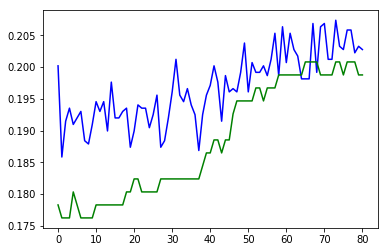

Starting epoch: 82 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.198770


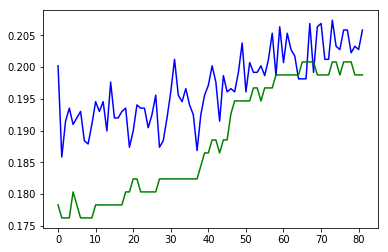

Starting epoch: 83 / 20000
training... done
Train Acc.: 0.206879
Val. Acc.: 0.202869


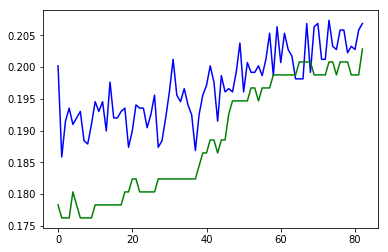

Starting epoch: 84 / 20000
training... done
Train Acc.: 0.206879
Val. Acc.: 0.202869


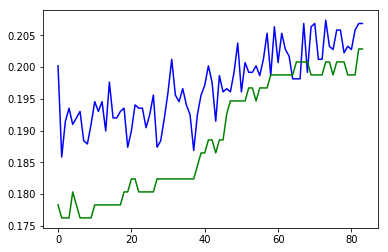

Starting epoch: 85 / 20000
training... done
Train Acc.: 0.204825
Val. Acc.: 0.202869


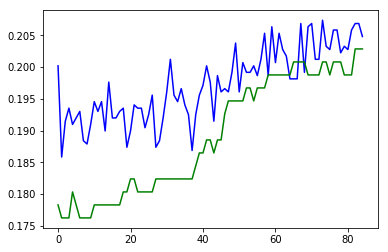

Starting epoch: 86 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.202869


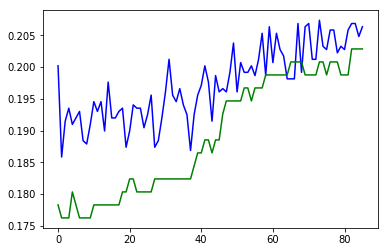

Starting epoch: 87 / 20000
training... done
Train Acc.: 0.207906
Val. Acc.: 0.202869


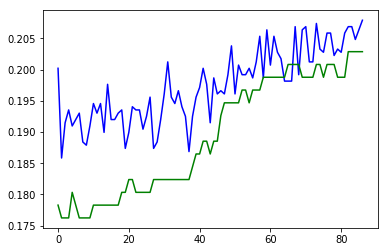

Starting epoch: 88 / 20000
training... done
Train Acc.: 0.203799
Val. Acc.: 0.202869


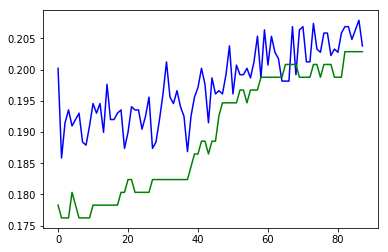

Starting epoch: 89 / 20000
training... done
Train Acc.: 0.207906
Val. Acc.: 0.202869


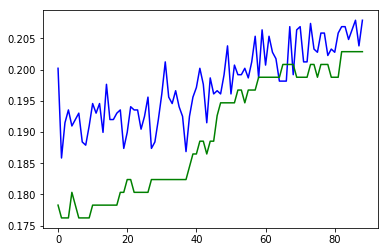

Starting epoch: 90 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.204918


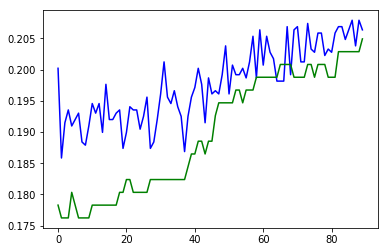

Starting epoch: 91 / 20000
training... done
Train Acc.: 0.201745
Val. Acc.: 0.204918


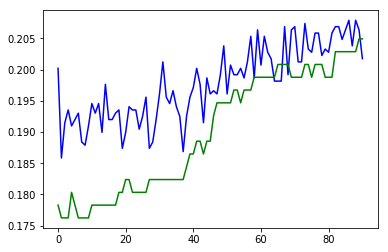

Starting epoch: 92 / 20000
training... done
Train Acc.: 0.208419
Val. Acc.: 0.204918


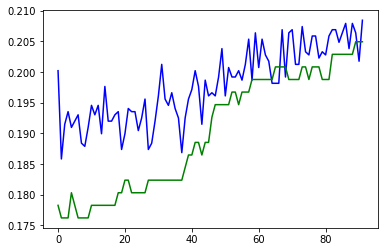

Starting epoch: 93 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.204918


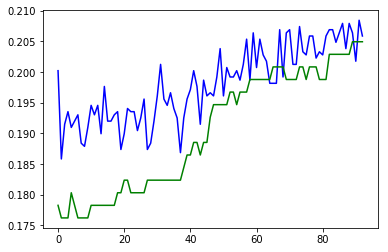

Starting epoch: 94 / 20000
training... done
Train Acc.: 0.203799
Val. Acc.: 0.204918


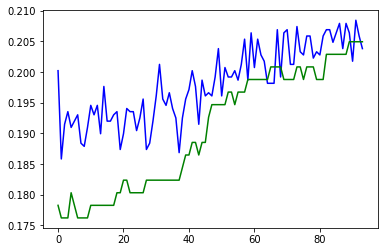

Starting epoch: 95 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.204918


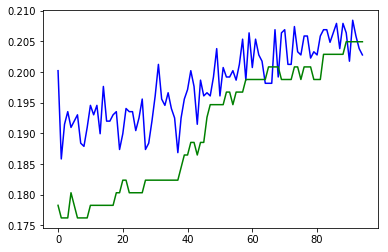

Starting epoch: 96 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.204918


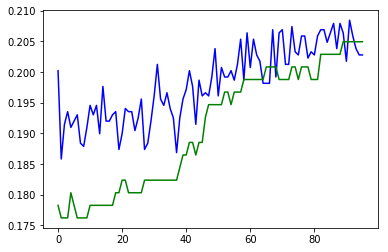

Starting epoch: 97 / 20000
training... done
Train Acc.: 0.203285
Val. Acc.: 0.206967


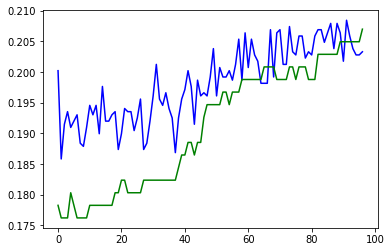

Starting epoch: 98 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.206967


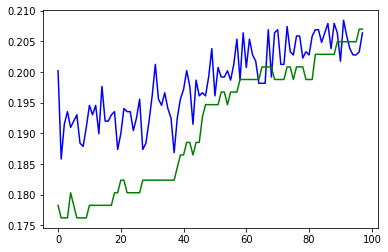

Starting epoch: 99 / 20000
training... done
Train Acc.: 0.201232
Val. Acc.: 0.206967


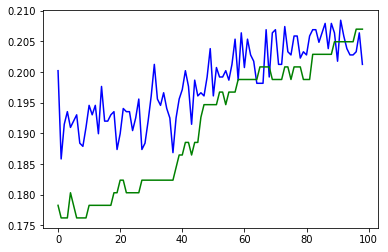

Starting epoch: 100 / 20000
training... done
Train Acc.: 0.197125
Val. Acc.: 0.206967


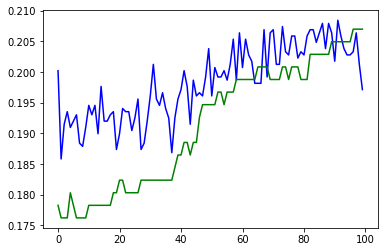

Starting epoch: 101 / 20000
training... done
Train Acc.: 0.201745
Val. Acc.: 0.204918


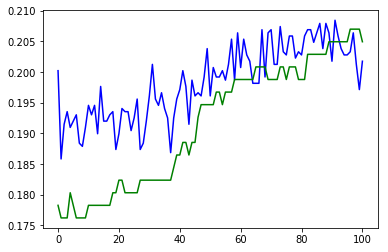

Starting epoch: 102 / 20000
training... done
Train Acc.: 0.204312
Val. Acc.: 0.202869


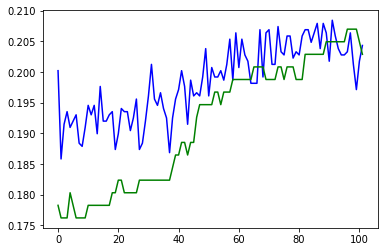

Starting epoch: 103 / 20000
training... done
Train Acc.: 0.201745
Val. Acc.: 0.202869


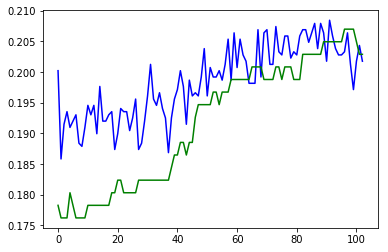

Starting epoch: 104 / 20000
training... done
Train Acc.: 0.206879
Val. Acc.: 0.202869


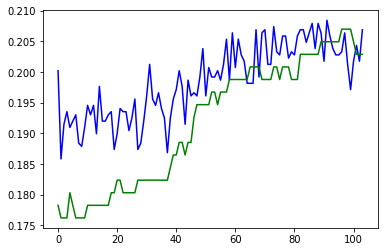

Starting epoch: 105 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.202869


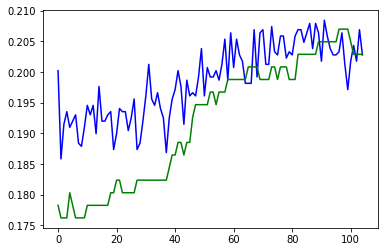

Starting epoch: 106 / 20000
training... done
Train Acc.: 0.207906
Val. Acc.: 0.202869


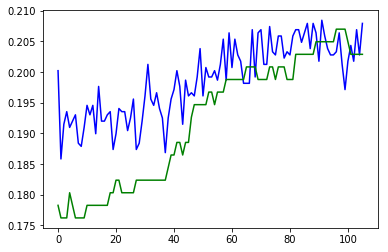

Starting epoch: 107 / 20000
training... done
Train Acc.: 0.208419
Val. Acc.: 0.200820


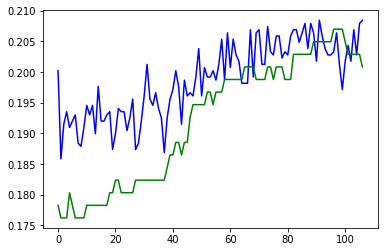

Starting epoch: 108 / 20000
training... done
Train Acc.: 0.203285
Val. Acc.: 0.198770


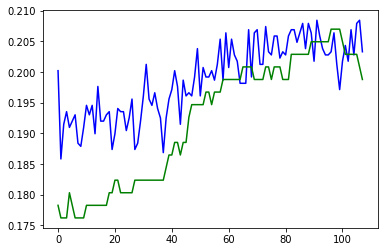

Starting epoch: 109 / 20000
training... done
Train Acc.: 0.206366
Val. Acc.: 0.198770


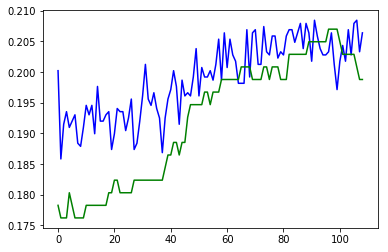

Starting epoch: 110 / 20000
training... done
Train Acc.: 0.201745
Val. Acc.: 0.198770


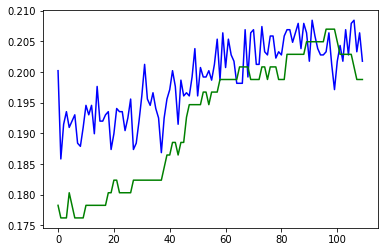

Starting epoch: 111 / 20000
training... done
Train Acc.: 0.208932
Val. Acc.: 0.198770


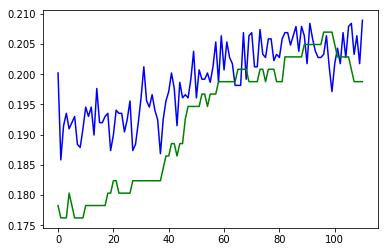

Starting epoch: 112 / 20000
training... done
Train Acc.: 0.205339
Val. Acc.: 0.198770


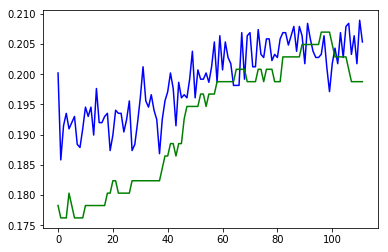

Starting epoch: 113 / 20000
training... done
Train Acc.: 0.202772
Val. Acc.: 0.198770


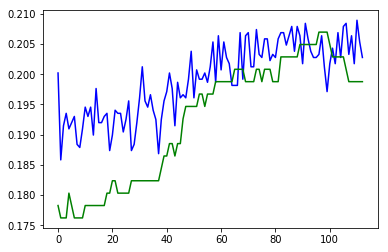

Starting epoch: 114 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.198770


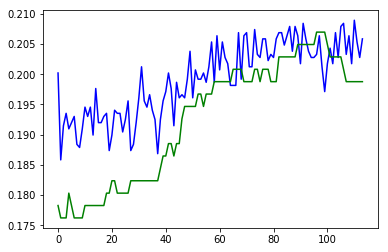

Starting epoch: 115 / 20000
training... done
Train Acc.: 0.205852
Val. Acc.: 0.200820


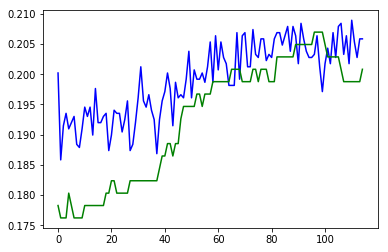

Starting epoch: 116 / 20000
training... done


In [ ]:
#begin training for the logit/auxlogit layers 
for ep in range(epochs):
    
    #starting training set iterator
    print 'Starting epoch: %d / %d' % (ep + 1, epochs)
    sess.run(train_init_op)
    print 'training...',
    while True: #run while iterator is non-empty
        try:
            _ = sess.run(logit_train_op, {is_training:True})
            _ = sess.run(auxlogit_train_op, {is_training:True})
        except tf.errors.OutOfRangeError:
            break
        
    print 'done'
        #train and val. acc
        
#     train_acc = get_accuracy(sess, predictions, labels, is_training, train_init_op)
#     val_acc = get_accuracy(sess, predictions, labels, is_training, val_init_op)
#     train_acc = check_accuracy(sess, predictions, is_training, train_init_op)
#     val_acc = check_accuracy(sess, predictions, is_training, val_init_op)

    train_acc = check_accuracy(sess, correct_predictions, is_training, train_init_op)
    val_acc = check_accuracy(sess, correct_predictions, is_training, val_init_op)
    
#     my_p, my_l = get_predictions(sess, predictions, labels, is_training, val_init_op)
    
#     print "predictions: "
#     print my_p
#     print "labels: "
#     print my_l
    
    print 'Train Acc.: %f' % train_acc
    print 'Val. Acc.: %f' % val_acc
        
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)
        
    #plotting
    t = range(len(train_acc_all))
    plt.plot(t, train_acc_all, 'b')
    plt.plot(t, val_acc_all, 'g')
    plt.show()

In [28]:
save_path = saver.save(sess, './checkpoint/rijks_inception_resnet_v2.ckpt')

In [34]:
#training all layers with smaller learning rate
epochs = 10000

for ep in range(epochs):
    
    #starting training set iterator
    print 'Starting epoch: %d / %d' % (ep + 1, epochs)
    sess.run(train_init_op)
    print 'training...',
    while True: #run while iterator is non-empty
        try:
            _ = sess.run(full_train_op, {is_training:True})
        except tf.errors.OutOfRangeError:
            break
        
    print 'done'
        #train and val. acc

    train_acc = check_accuracy(sess, correct_predictions, is_training, train_init_op)
    val_acc = check_accuracy(sess, correct_predictions, is_training, val_init_op)
    
    print 'Train Acc.: %f' % train_acc
    print 'Val. Acc.: %f' % val_acc
        
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)
        
    #plotting
    t = range(len(train_acc_all))
    plt.plot(t, train_acc_all, 'b')
    plt.plot(t, val_acc_all, 'g')
    plt.show()

Starting epoch: 1 / 10000
training...

ResourceExhaustedError: OOM when allocating tensor with shape[128,160,12,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/Conv2D = Conv2D[T=DT_FLOAT, _class=["loc:@Incep...m_1/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0a_1x1/Relu, InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/weights/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-370c0ca3d8b6>", line 3, in <module>
    output, _ = inception_resnet_v2(images, num_classes=num_classes, is_training=is_training) #initialize model
  File "inception_resnet_v2.py", line 188, in inception_resnet_v2
    net = slim.repeat(net, 20, block17, scale=0.10)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 2605, in repeat
    outputs = layer(outputs, *args, **kwargs)
  File "inception_resnet_v2.py", line 60, in block17
    scope='Conv2d_0b_1x7')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1154, in convolution2d
    conv_dims=2)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1057, in convolution
    outputs = layer.apply(inputs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/_impl/keras/engine/base_layer.py", line 757, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/base.py", line 318, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/_impl/keras/engine/base_layer.py", line 686, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/_impl/keras/layers/convolutional.py", line 184, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3408, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1734, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,160,12,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/Conv2D = Conv2D[T=DT_FLOAT, _class=["loc:@Incep...m_1/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0a_1x1/Relu, InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/weights/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

